# Cifar10 Outlier Detection
![demo](./demo.png)

In this example we will deploy an image classification model along with an outlier detector trained on the same dataset. For in depth details on creating an outlier detection model for your own dataset see the [alibi-detect project](https://github.com/SeldonIO/alibi-detect) and associated [documentation](https://docs.seldon.io/projects/alibi-detect/en/latest/). You can find details for this [CIFAR10 example in their documentation](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/od_vae_cifar10.html) as well.


Prequisites:

  * [Knative eventing installed](https://knative.dev/docs/install/)
    * Ensure the istio-ingressgateway is exposed as a loadbalancer (no auth in this demo)
  * [Seldon Core installed](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/install.html) 
    * Ensure you install for istio, e.g. for the helm chart `--set istio.enabled=true`
    
    Tested on GKE and Kind with Knative 0.18 and Istio 1.7.3

In [2]:
!pip install -r requirements_notebook.txt

     |████████████████████████████████| 150 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 50.4 MB 4.6 MB/s eta 0:00:01    |███                             | 4.8 MB 2.7 MB/s eta 0:00:17     |███████████████████████████     | 42.4 MB 1.7 MB/s eta 0:00:05
     |████████████████████████████████| 4.8 MB 4.4 MB/s eta 0:00:01
  Using cached grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
     |████████████████████████████████| 93 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 2.5 MB/s eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.37.0
    Uninstalling grpcio-1.37.0:
      Successfully uninstalled grpcio-1.37.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependen

Ensure istio gateway installed

In [3]:
!kubectl apply -f ../../../notebooks/resources/seldon-gateway.yaml

gateway.networking.istio.io/seldon-gateway unchanged


In [3]:
!cat ../../../notebooks/resources/seldon-gateway.yaml

apiVersion: networking.istio.io/v1alpha3
kind: Gateway
metadata:
  name: seldon-gateway
  namespace: istio-system
spec:
  selector:
    istio: ingressgateway # use istio default controller
  servers:
  - port:
      number: 80
      name: http
      protocol: HTTP
    hosts:
    - "*"


## Setup Resources

In [4]:
!kubectl create namespace cifar10

namespace/cifar10 created


In [5]:
%%writefile broker.yaml
apiVersion: eventing.knative.dev/v1
kind: broker
metadata:
 name: default
 namespace: cifar10

Writing broker.yaml


In [6]:
!kubectl create -f broker.yaml

broker.eventing.knative.dev/default created


In [7]:
%%writefile event-display.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: hello-display
  namespace: cifar10
spec:
  replicas: 1
  selector:
    matchLabels: &labels
      app: hello-display
  template:
    metadata:
      labels: *labels
    spec:
      containers:
        - name: event-display
          image: gcr.io/knative-releases/knative.dev/eventing-contrib/cmd/event_display

---

kind: Service
apiVersion: v1
metadata:
  name: hello-display
  namespace: cifar10
spec:
  selector:
    app: hello-display
  ports:
  - protocol: TCP
    port: 80
    targetPort: 8080

Writing event-display.yaml


In [8]:
!kubectl apply -f event-display.yaml

deployment.apps/hello-display created
service/hello-display created


Create the SeldonDeployment image classification model for Cifar10. We add in a `logger` for requests - the default destination is the namespace Knative Broker.

In [11]:
%%writefile cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: tfserving-cifar10
  namespace: cifar10
spec:
  protocol: tensorflow
  transport: rest
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - args: 
          - --port=8500
          - --rest_api_port=8501
          - --model_name=resnet32
          - --model_base_path=gs://seldon-models/tfserving/cifar10/resnet32
          image: tensorflow/serving
          name: resnet32
          ports:
          - containerPort: 8501
            name: http
            protocol: TCP
    graph:
      name: resnet32
      type: MODEL
      endpoint:
        service_port: 8501
      logger:
        mode: all
        url: http://broker-ingress.knative-eventing.svc.cluster.local/cifar10/default
    name: model
    replicas: 1


Overwriting cifar10.yaml


In [12]:
!kubectl apply -f cifar10.yaml

seldondeployment.machinelearning.seldon.io/tfserving-cifar10 unchanged


Create the pretrained VAE Cifar10 Outlier Detector. We forward replies to the message-dumper we started.

In [179]:
%%writefile cifar10od.yaml

apiVersion: v1
kind: Secret
metadata:
  name: seldon-rclone-secret
  namespace: cifar10    
type: Opaque
stringData:
  RCLONE_CONFIG_GS_TYPE: google cloud storage
  RCLONE_CONFIG_GS_ANONYMOUS: "true"

---            

apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: vae-outlier
  namespace: cifar10
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: dev.local/alibi-detect-server:1.8.0-dev
        imagePullPolicy: Never
        args:
        - --model_name
        - cifar10od
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/od/OutlierVAE/cifar10
        - --reply_url
        - http://hello-display.cifar10
        - --event_type
        - io.seldon.serving.inference.outlier
        - --event_source
        - io.seldon.serving.cifar10od
        - OutlierDetector
        envFrom:
        - secretRef:
            name: seldon-rclone-secret

Overwriting cifar10od.yaml


In [180]:
!kubectl apply -f cifar10od.yaml

secret/seldon-rclone-secret configured
service.serving.knative.dev/vae-outlier configured


Create a Knative trigger to forward logging events to our Outlier Detector.

In [181]:
%%writefile trigger.yaml
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: vaeoutlier-trigger
  namespace: cifar10
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: vae-outlier
      namespace: cifar10


Overwriting trigger.yaml


In [182]:
!kubectl apply -f trigger.yaml

trigger.eventing.knative.dev/vaeoutlier-trigger unchanged


Get the IP address of the Istio Ingress Gateway. This assumes you have installed istio with a LoadBalancer.

In [183]:
CLUSTER_IPS=!(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP=CLUSTER_IPS[0]
print(CLUSTER_IP)

172.18.255.1


Optionally add an authorization token here if you need one.Acquiring this token will be dependent on your auth setup.

In [184]:
TOKEN="Bearer <my token>"

If you are using Kind or Minikube you will need to port-forward to the istio ingressgateway and uncomment the following

In [185]:
#CLUSTER_IP="localhost:8004"

In [186]:
SERVICE_HOSTNAMES=!(kubectl get ksvc -n cifar10 vae-outlier -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_VAEOD=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_VAEOD)

vae-outlier.cifar10.example.com


In [192]:
SERVICE_HOSTNAME_VAEOD

'vae-outlier.cifar10.example.com'

In [193]:
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
tf.keras.backend.clear_session()

from alibi_detect.od.vae import OutlierVAE
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.visualize import plot_feature_outlier_image
import requests

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

def predict(X):
    formData = {
    'instances': X.tolist()
    }
    headers = {"Authorization":TOKEN}
    res = requests.post('http://'+CLUSTER_IP+'/seldon/cifar10/tfserving-cifar10/v1/models/resnet32/:predict', json=formData, headers=headers)
    if res.status_code == 200:
        return classes[np.array(res.json()["predictions"])[0].argmax()]
    else:
        print("Failed with ",res.status_code)
        return []
    
def outlier(X):
    formData = {
    'instances': X.tolist()
    }
    headers = {"Alibi-Detect-Return-Feature-Score":"true","Alibi-Detect-Return-Instance-Score":"true", \
                "ce-namespace": "default","ce-modelid":"cifar10","ce-type":"io.seldon.serving.inference.request", \
                "ce-id":"1234","ce-source":"localhost","ce-specversion":"1.0"}
    headers["Host"] = SERVICE_HOSTNAME_VAEOD
    headers["Authorization"] = TOKEN
    res = requests.post('http://'+CLUSTER_IP+'/', json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        od["data"]["feature_score"] = np.array(od["data"]["feature_score"])
        od["data"]["instance_score"] = np.array(od["data"]["instance_score"])
        return od
    else:
        print("Failed with ",res.status_code)
        return []

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Normal Prediction

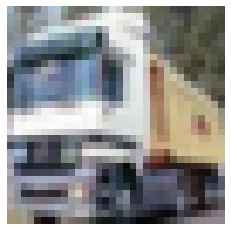

'truck'

In [194]:
idx = 1
X = X_train[idx:idx+1]
show(X)
predict(X)

Lets check the message dumper for an outlier detection prediction. This should be false.

In [195]:
res=!kubectl logs -n cifar10 $(kubectl get pod -n cifar10 -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[0]))
print("Outlier",j["data"]["is_outlier"]==[1])

Outlier False


## Outlier Prediction

In [199]:
np.random.seed(0) 
X_mask, mask = apply_mask(X.reshape(1, 32, 32, 3),
                                  mask_size=(10,10),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))

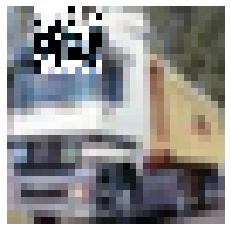

'truck'

In [200]:
show(X_mask)
predict(X_mask)

Now lets check the message dumper for a new message. This should show we have found an outlier.

In [198]:
res=!kubectl logs -n cifar10 $(kubectl get pod -n cifar10 -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[-1]))
print("Outlier",j["data"]["is_outlier"]==[1])

Outlier True


We will now call our outlier detector directly and ask for the feature scores to gain more information about why it predicted this instance was an outlier.

In [81]:
od_preds = outlier(X_mask)

We now plot those feature scores returned by the outlier detector along with our original image.

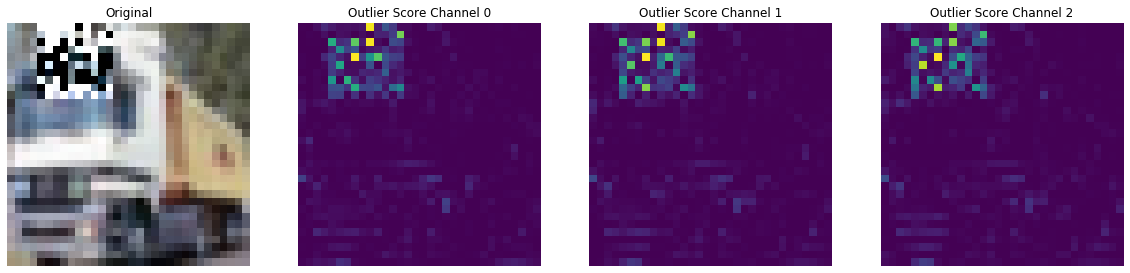

In [67]:
plot_feature_outlier_image(od_preds, 
                           X_mask, 
                           X_recon=None)

## Tear Down

In [29]:
!kubectl delete ns cifar10

namespace "cifar10" deleted
